In [1]:
!pip install numpy==1.16.1
!pip install keras==2.1.2

from __future__ import print_function
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, CuDNNLSTM, Bidirectional
from keras.datasets import imdb

def get_lstm(size, return_sequences=True):
    return CuDNNLSTM(size, return_sequences=return_sequences)

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_val = x_test[0:len(x_test)//2]
y_val = x_test[0:len(y_test)//2]
x_test = x_test[len(x_test)//2 : ]
y_test = x_test[len(y_test)//2 : ]
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print(len(x_val), 'validation sequences')

def compress(x, y):
    xout = []
    yout = []
    for i in range(len(x)):
        if x[i][0] != 0:
            xout.append(x[i])
            yout.append(y[i])
    xa = np.array(xout)
    print(xa.shape)
    return np.array(xout), np.array(yout)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
x_val = sequence.pad_sequences(x_val, maxlen=maxlen)
#y_train = np.array(y_train)
#y_test = np.array(y_test)
y_train = np.expand_dims(np.array(x_train), -1)
y_test = np.expand_dims(np.array(x_test), -1)
y_val = np.expand_dims(np.array(x_val), -1)
(x_train, y_train) = compress(x_train, y_train)
(x_test, y_test) = compress(x_test, y_test)
(x_val, y_val) = compress(x_val, y_val)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_val shape:', x_val.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_val shape:', y_val.shape)

def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=5):
    # If the shape of y_true is (num_samples, 1), flatten to (num_samples,)
    return K.cast(K.in_top_k(y_pred, K.cast(K.flatten(y_true), 'int32'), k),
                  K.floatx())

def sparse_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5):
    # If the shape of y_true is (num_samples, 1), flatten to (num_samples,)
    return K.cast(K.in_top_k(y_pred, K.cast(K.flatten(y_true), 'int32'), k),
                  K.floatx())

def sparse(y_true, y_pred):
    return sparse_categorical_accuracy(y_true, y_pred)
def sequence(y_true, y_pred):
    return sparse_categorical_accuracy_per_sequence(y_true, y_pred)
def sparse_k(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred)
def sequence_k(y_true, y_pred):
    return sparse_categorical_accuracy_top_k_per_sequence(y_true, y_pred)

def test_top_k_categorical_accuracy():
    y_pred = K.variable(np.array([[0.3, 0.2, 0.1], [0.1, 0.2, 0.7]]))
    y_true = K.variable(np.array([[0, 1, 0], [1, 0, 0]]))
    success_result = K.eval(metrics.top_k_categorical_accuracy(y_true, y_pred,
                                                               k=3))
    assert np.mean(success_result) == 1
    partial_result = K.eval(metrics.top_k_categorical_accuracy(y_true, y_pred,
                                                               k=2))
    assert np.mean(partial_result) == 0.5
    failure_result = K.eval(metrics.top_k_categorical_accuracy(y_true, y_pred,
                                                               k=1))
    assert np.mean(failure_result) == 0


units=16

model = Sequential()
model.add(Embedding(max_features, units*2, input_length=maxlen))
model.add(Bidirectional(get_lstm(units, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(max_features, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'sparse_categorical_crossentropy', metrics=[sparse, sequence])
model.summary()

print('Train...')
history = None
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=2,
          validation_data=[x_test, y_test])

Using TensorFlow backend.


Loading data...
25000 train sequences
12500 test sequences
12500 validation sequences
Pad sequences (samples x time)


W0619 21:27:01.368257 140490570119040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:64: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 21:27:01.383125 140490570119040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:497: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 21:27:01.387421 140490570119040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3636: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



(22227, 100)
(11012, 100)
(11025, 100)
x_train shape: (22227, 100)
x_test shape: (11012, 100)
x_val shape: (11025, 100)
y_train shape: (22227, 100, 1)
y_test shape: (11012, 100, 1)
y_val shape: (11025, 100, 1)


W0619 21:27:02.226286 140490570119040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1247: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0619 21:27:02.422053 140490570119040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3019: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0619 21:27:02.458566 140490570119040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1213: calling reduce_max_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 32)           6400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 20000)        660000    
Total params: 1,306,400
Trainable params: 1,306,400
Non-trainable params: 0
_________________________________________________________________
Train...


W0619 21:27:02.965644 140490570119040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:958: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0619 21:27:02.979163 140490570119040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:680: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 22227 samples, validate on 11012 samples
Epoch 1/30
 - 105s - loss: 6.7257 - sparse: 0.0514 - sequence: 0.0000e+00 - val_loss: 6.0533 - val_sparse: 0.0552 - val_sequence: 0.0000e+00
Epoch 2/30
 - 102s - loss: 5.9447 - sparse: 0.0548 - sequence: 0.0000e+00 - val_loss: 5.6575 - val_sparse: 0.0552 - val_sequence: 0.0000e+00
Epoch 3/30
 - 102s - loss: 5.5278 - sparse: 0.0649 - sequence: 0.0000e+00 - val_loss: 5.1200 - val_sparse: 0.1167 - val_sequence: 0.0000e+00
Epoch 4/30
 - 102s - loss: 5.0858 - sparse: 0.0947 - sequence: 0.0000e+00 - val_loss: 4.6250 - val_sparse: 0.1886 - val_sequence: 0.0000e+00
Epoch 5/30
 - 102s - loss: 4.6219 - sparse: 0.1353 - sequence: 0.0000e+00 - val_loss: 4.0007 - val_sparse: 0.2747 - val_sequence: 0.0000e+00
Epoch 6/30
 - 102s - loss: 4.2079 - sparse: 0.1780 - sequence: 0.0000e+00 - val_loss: 3.5236 - val_sparse: 0.3588 - val_sequence: 0.0000e+00
Epoch 7/30
 - 102s - loss: 3.7759 - sparse: 0.2510 - sequence: 0.0000e+00 - val_loss: 2.8598 - val_spars

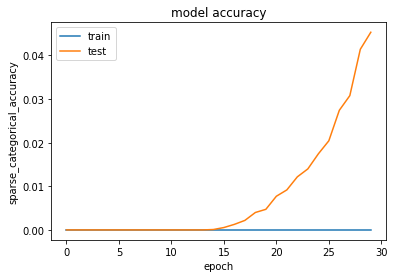

In [2]:

if history != None:
  # summarize history for accuracy
  plt.plot(history.history['sparse'])
  plt.plot(history.history['val_sparse'])
  plt.title('model accuracy')
  plt.ylabel('sparse_categorical_accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [3]:
short = x_val[0:100]

if True:
#with tf.Session() as session:
#  K.set_session(session)
#  session.run(tf.global_variables_initializer())
#  session.run(tf.tables_initializer())
  #model.load_weights('./model.h5')  
  eval = model.evaluate(x_val, y_val)
  print('model.evaluate on val holdout: ' ,model.metrics_names, eval)
  print('history: ', history)
  predicts = model.predict(short, batch_size=32)
  print('shape: {}'.format(predicts.shape))

print(len(predicts[0]))
print(len(predicts[0][0]))
print(predicts[0])

11025/11025 [==============================] - 20s 2ms/step
model.evaluate on val holdout:  ['loss', 'sparse', 'sequence'] [0.4216869519762441, 0.9597560077513697, 0.04417233560124492]
history:  <keras.callbacks.History object at 0x7fc625786a58>
shape: (100, 100, 20000)
100
20000
[[1.0213755e-18 2.1669586e-18 2.4100757e-13 ... 7.5307121e-21
  1.7676047e-22 1.2392732e-25]
 [8.1977246e-12 3.7876737e-09 1.3391892e-06 ... 1.0526842e-09
  4.5809236e-14 1.0058988e-09]
 [1.1759797e-10 1.3913035e-08 8.1781621e-09 ... 4.9446470e-08
  3.4127712e-08 1.0619011e-09]
 ...
 [9.2855955e-16 2.0520503e-17 2.8446085e-13 ... 5.0007432e-17
  3.7405610e-15 1.1881861e-21]
 [7.8344126e-21 1.9702042e-18 7.7574420e-15 ... 3.4856338e-22
  5.8134182e-25 1.3493316e-24]
 [2.5707738e-09 4.2684383e-07 2.1300134e-03 ... 1.3003063e-07
  1.7719579e-09 5.0279020e-08]]


In [4]:
def maxindx(pred):
    maxi=-1
    maxv=-1.0
    for x in range(len(pred)):
        if pred[x] > maxv:
            maxv = pred[x]
            maxi = x
    return (maxi, maxv)

def match(data, prediction):
    good = 0
    total = 0
    for i in range(len(data)):
       # if data[i] < 0.000001:
       #     break
        if data[i] == np.argmax(prediction[i]):
            good += 1
        total += 1
    #print('{}, {}'.format(good, total))
    if (total == 0):
        return 0
    return good / total

good = 0.0
total = 0
for n in range(len(short)):
    #print(short[n][0:5])
    if short[n][0] != 0 or True:
        check = match(short[n], predicts[n])
        if check > 0.9999:
            good += 1
    total += 1

print('Score: ', good / total)
print('values: ', maxindx(predicts[0][0]))

Score:  0.02
values:  (6, 0.9999993)
